In [ ]:
! az login

In [5]:
! pip install matplotlib onnx
! wget https://www.cntk.ai/OnnxModels/tiny_yolov2/opset_7/tiny_yolov2.tar.gz
! tar xvzf tiny_yolov2.tar.gz

    100% |████████████████████████████████| 6.7MB 190kB/s eta 0:00:01
  Found existing installation: typing 3.6.2
    Uninstalling typing-3.6.2:
      Successfully uninstalled typing-3.6.2
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
--2018-10-21 01:14:20--  https://www.cntk.ai/OnnxModels/tiny_yolov2/opset_7/tiny_yolov2.tar.gz
Resolving webproxy (webproxy)... 10.36.59.1
Connecting to webproxy (webproxy)|10.36.59.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 60777153 (58M) [application/x-gzip]
Saving to: ‘tiny_yolov2.tar.gz’

tiny_yolov2.tar.gz  100%[===================>]  57.96M  1.70MB/s    in 27s     

2018-10-21 01:14:48 (2.18 MB/s) - ‘tiny_yolov2.tar.gz’ saved [60777153/60777153]

tiny_yolov2/
tiny_yolov2/model.onnx
tiny_yolov2/test_data_set_0/
tiny_yolov2/test_data_set_0/input_0.pb
tiny_yolov2/test_data_set_0/output_0.pb
tiny_yolov2/test_data_set_1/
tiny

In [6]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 0.1.65


In [ ]:
from azureml.core import Workspace

ws = Workspace(subscription_id="YOUR SUBSCRIPTION ID", resource_group="YoloSandboxGroup", workspace_name="YoloSandbox")
print(ws.name, ws.resource_group, ws.location, sep = '\n')

In [8]:
from azureml.core.model import Model

model_dir = "tiny_yolov2"
model = Model.register(model_path = model_dir + "//model.onnx",
                       model_name = "tiny_yolov2",
                       tags = {"onnx": "demo"},
                       description = "Tiny YOLO model",
                       workspace = ws)

Registering model tiny_yolov2


In [23]:
%%writefile score.py
import json
import numpy as np
import onnxruntime
import sys
import os
from azureml.core.model import Model
import time
from json_tricks import dumps

def init():
    global session, input_name, output_name
    model = Model.get_model_path(model_name = 'tiny_yolov2')
    session = onnxruntime.InferenceSession(model, None)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name 
    
def run(input_data):
    '''Purpose: evaluate test input in Azure Cloud using onnxruntime.
        We will call the run function later from our Jupyter Notebook 
        so our azure service can evaluate our model input in the cloud. '''
    try:
        # load in our data, convert to readable format
        data = np.array(json.loads(input_data)['data']).astype('float32')
        start = time.time()
        r = session.run([output_name], {input_name: data})[0]
        end = time.time()
        serialised = dumps(r)
        result_dict = {"result": serialised,
                      "time_in_sec": [end - start]}
    except Exception as e:
        result_dict = json.dumps({"error": str(e)})
    return result_dict

Overwriting score.py


In [24]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies()
myenv.add_pip_package("numpy")
myenv.add_pip_package("azureml-core")
myenv.add_pip_package("onnxruntime")
myenv.add_pip_package("json-tricks")
with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [25]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "A container image to host YOLO model",
                                                  tags = {"demo": "onnx"})
image = ContainerImage.create(name = "yoloimage",
                              # this is the model object
                              models = [model],
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running...................
SucceededImage creation operation finished for image yoloimage:3, operation "Succeeded"


In [ ]:
print(image.image_build_log_uri)

In [27]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 2, 
                                               memory_gb = 4, 
                                               tags = {'demo': 'onnx'}, 
                                               description = 'ONNX for yolo model')

In [28]:
from azureml.core.webservice import Webservice

aci_service_name = 'onnx-demo-yolo'
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)

print(aci_service.state)

Creating service
Running..............................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


In [29]:
print(aci_service.scoring_uri)

http://104.41.132.101:80/score


In [30]:
! wget https://raw.githubusercontent.com/ylashin/ConsumeOnnxUsingAzureML/master/Test.jpg

--2018-10-21 02:33:49--  https://raw.githubusercontent.com/ylashin/ConsumeOnnxUsingAzureML/master/Test.jpg
Resolving webproxy (webproxy)... 10.36.59.1
Connecting to webproxy (webproxy)|10.36.59.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 81971 (80K) [image/jpeg]
Saving to: ‘Test.jpg’

Test.jpg            100%[===================>]  80.05K  --.-KB/s    in 0.06s   

2018-10-21 02:33:50 (1.29 MB/s) - ‘Test.jpg’ saved [81971/81971]



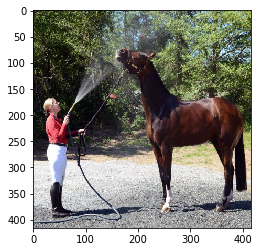

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


img = mpimg.imread("Test.jpg")
plt.imshow(img)

In [33]:
import numpy as np

img = img.transpose(2, 0, 1)
img = np.expand_dims(img, axis=0)

print("Image Dimensions: ", img.shape)

Image Dimensions:  (1, 3, 416, 416)


In [34]:
import json

input_data = json.dumps({'data': img.tolist()})

try:
    response = aci_service.run(input_data)
    print(response)
except Exception as e:
    print(str(e))

{'time_in_sec': [0.10004520416259766], 'result': '{"__ndarray__": [[[[-0.14387448132038116, 0.08836790174245834, 0.35421058535575867, 0.1865989714860916, -0.11009418219327927, -0.07205414026975632, 0.04996097832918167, 0.21800550818443298, 0.17318283021450043, 0.032153040170669556, -0.11873271316289902, 0.1006208136677742, 0.1354161500930786], [-0.31877827644348145, 0.07046016305685043, 0.1801544576883316, 0.2309739589691162, 0.5398209691047668, 0.6008049845695496, -0.245177760720253, -0.36770713329315186, 0.10166818648576736, 0.40024423599243164, 0.4370933771133423, 0.37264111638069153, 0.12009251862764359], [-0.23524492979049683, 0.3195999562740326, -0.033432893455028534, 0.004191257059574127, 0.9217534065246582, 1.1822891235351562, -0.39489689469337463, -0.848928689956665, -0.1559654176235199, 0.4991084337234497, 0.6411013007164001, 0.4648756980895996, 0.028122909367084503], [-0.12647795677185059, 0.06009278446435928, -0.05630212277173996, -0.04712899774312973, 0.4981505274772644, 0